<a href="https://colab.research.google.com/github/npl0204/Salary-Prediction/blob/main/SalaryPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip installation from PyPI

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import needed packages**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use("ggplot")
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import GBTRegressor, LinearRegression

from pyspark.shell import spark

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.7.13 (default, Apr 24 2022 01:04:09)
Spark context Web UI available at http://d58daac6eb5b:4040
Spark context available as 'sc' (master = local[*], app id = local-1655403478491).
SparkSession available as 'spark'.


# **Load data**

In [6]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [7]:
trainData = sqlContext.read.format("com.databricks.spark.csv").options(header = "true", inferschema = "true").load("/content/drive/MyDrive/INFO 103 Project/train_dataset.csv")
trainData.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [8]:
trainSalaries = sqlContext.read.format("com.databricks.spark.csv").options(header = "true", inferschema = "true").load("/content/drive/MyDrive/INFO 103 Project/train_salaries.csv")
trainSalaries.show(5)

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows



# **Data pre-processing**

Combine salaries to train set

In [9]:
trainSalaries = trainSalaries.withColumnRenamed("jobId", "job_id")
train = trainData.join(trainSalaries, trainData.jobId == trainSalaries.job_id)
train = train.drop("job_id")
train.show(5)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407695|   COMP20|       JANITOR|HIGH_SCHOOL|     NONE|EDUCATION|              1|                 54|    31|
|JOB1362684407696|   COMP41|VICE_PRESIDENT|  BACHELORS|CHEMISTRY|     AUTO|             17|                 68|   104|
+----------------+---------+--------------+-----

Check missing value

In [10]:
print("Number of missing values for degree: {}".format(train.filter(train.companyId == "NONE").count()))
print("Number of missing values for jobType: {}".format(train.filter(train.jobType == "NONE").count()))
print("Number of missing values for degree: {}".format(train.filter(train.degree == "NONE").count()))
print("Number of missing values for major: {}".format(train.filter(train.major == "NONE").count()))
print("Number of missing values for industry: {}".format(train.filter(train.industry == "NONE").count()))
print("Number of missing values for yearsExperience: {}".format(train.filter(train.yearsExperience == "NONE").count()))
print("Number of missing values for milesFromMetropolis: {}".format(train.filter(train.milesFromMetropolis == "NONE").count()))
print("Number of missing values for salary: {}".format(train.filter(train.salary == "NONE").count())) 

Number of missing values for degree: 0
Number of missing values for jobType: 0
Number of missing values for degree: 236854
Number of missing values for major: 532355
Number of missing values for industry: 0
Number of missing values for yearsExperience: 0
Number of missing values for milesFromMetropolis: 0
Number of missing values for salary: 0


In order to perform SQL queries on the dataset, we must create a table based on the spark dataframe, as follows:

In [11]:
train.createOrReplaceTempView("data")

We can easily observe that the occupations with \$0 salaries are most likely missing values, as they are tied to high-paying industries like OIL and WEB. Furthermore, there is a "vice president" position, which cannot be paid \$0. These rows will be removed.

In [12]:
train = train.where("salary != 0")

 Reload the table since we updated the dataframe

In [13]:
train.createOrReplaceTempView("data")

# **Data analysis**

Convert train (type pyspark.sql.dataframe.DataFrame) to Data Frame for easier visualization

In [14]:
trainDataFrame = train.toPandas()

### Distribution of dataset

In [15]:
trainDataFrame.groupby("jobType").salary.count()

jobType
CEO               124778
CFO               124369
CTO               125045
JANITOR           124971
JUNIOR            124592
MANAGER           125120
SENIOR            125886
VICE_PRESIDENT    125234
Name: salary, dtype: int64

In [16]:
trainDataFrame.groupby("industry").salary.count()

industry
AUTO         142941
EDUCATION    142819
FINANCE      142866
HEALTH       142755
OIL          142770
SERVICE      142639
WEB          143205
Name: salary, dtype: int64

In [17]:
trainDataFrame.groupby("degree").salary.count()

degree
BACHELORS      175495
DOCTORAL       175362
HIGH_SCHOOL    236975
MASTERS        175310
NONE           236853
Name: salary, dtype: int64

In [18]:
trainDataFrame.groupby("major").salary.count()

major
BIOLOGY         58379
BUSINESS        58518
CHEMISTRY       58875
COMPSCI         58382
ENGINEERING     58594
LITERATURE      58684
MATH            57800
NONE           532353
PHYSICS         58410
Name: salary, dtype: int64

### Highest paid job.

In [19]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



According to the above table, the highest paid salary is 301k\$, which belongs to CFO and CTO of the OIL industry.

### Top 10 highest paid job

In [20]:
spark.sql('''
          SELECT salary, jobtype, industry
          FROM data
          ORDER BY salary DESC
          LIMIT 10''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
|   298|    CEO|     OIL|
|   294|    CEO| FINANCE|
|   294|    CEO|     OIL|
|   293|    CEO| FINANCE|
|   293|    CEO|     OIL|
|   292|    CTO| FINANCE|
|   292|    CEO| FINANCE|
|   290|    CEO|     WEB|
+------+-------+--------+



### Top 10 lowest paid job

In [21]:
spark.sql('''
          SELECT salary, jobtype, industry
          FROM data
          ORDER BY salary ASC
          LIMIT 10''').show()

+------+-------+---------+
|salary|jobtype| industry|
+------+-------+---------+
|    17|JANITOR|EDUCATION|
|    18|JANITOR|EDUCATION|
|    18|JANITOR|EDUCATION|
|    18|JANITOR|EDUCATION|
|    19|JANITOR|EDUCATION|
|    19|JANITOR|EDUCATION|
|    19|JANITOR|EDUCATION|
|    19|JANITOR|EDUCATION|
|    19|JANITOR|EDUCATION|
|    19|JANITOR|EDUCATION|
+------+-------+---------+



### Industry ranking in term of salary

In [22]:
industryRank = spark.sql('''
          SELECT industry, AVG(salary) as averageSalary
          FROM data
          GROUP BY industry
          ORDER BY averageSalary DESC''')
industryRank.show()

+---------+------------------+
| industry|     averageSalary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



Text(0, 0.5, 'Industry')

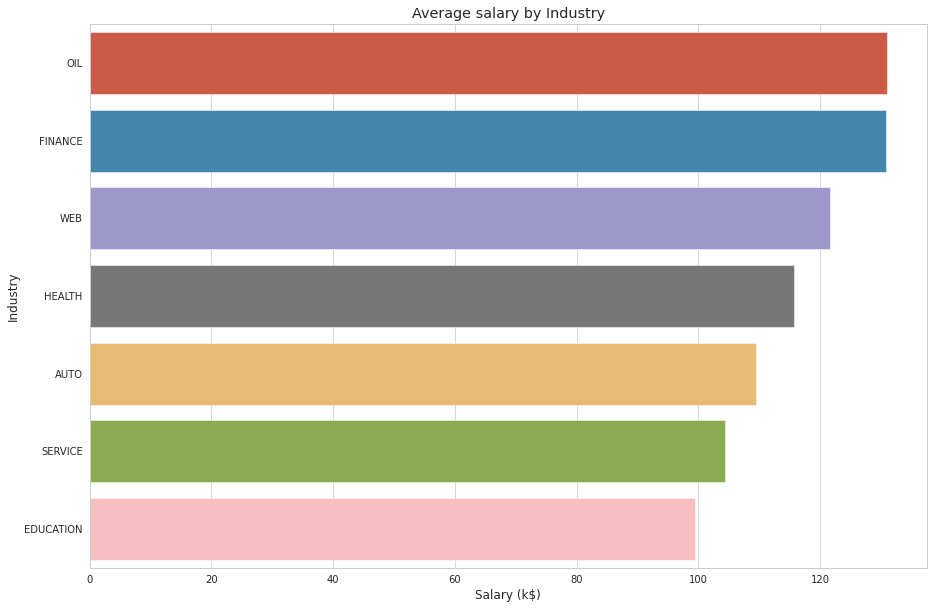

In [23]:
plt.figure(figsize = (15, 10))
sns.barplot(y = "industry", x = "averageSalary", data = industryRank.toPandas())
plt.title("Average salary by Industry")
plt.xlabel("Salary (k$)")
plt.ylabel("Industry")

### Jobtype ranking in term of salary

In [24]:
jobtypeRank = spark.sql('''
          SELECT jobType, AVG(salary) as averageSalary
          FROM data
          GROUP BY jobType
          ORDER BY averageSalary DESC''')
jobtypeRank.show()

+--------------+------------------+
|       jobType|     averageSalary|
+--------------+------------------+
|           CEO|145.31142509096154|
|           CTO|135.48106681594626|
|           CFO|135.45854674396352|
|VICE_PRESIDENT| 125.3686299247808|
|       MANAGER| 115.3685182225064|
|        SENIOR|105.48777465325772|
|        JUNIOR| 95.33308719660974|
|       JANITOR| 70.81304462635332|
+--------------+------------------+



Text(0, 0.5, 'Jobtype')

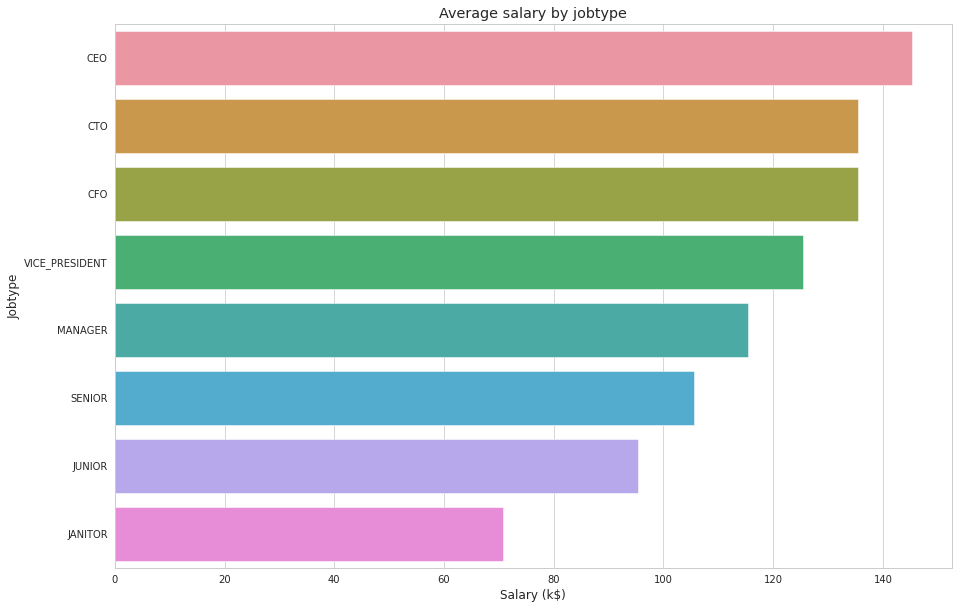

In [25]:
plt.figure(figsize = (15, 10))
sns.barplot(y = "jobType", x = "averageSalary", data = jobtypeRank.toPandas())
plt.title("Average salary by jobtype")
plt.xlabel("Salary (k$)")
plt.ylabel("Jobtype")

### Analyze the relationship between years of experience and salary

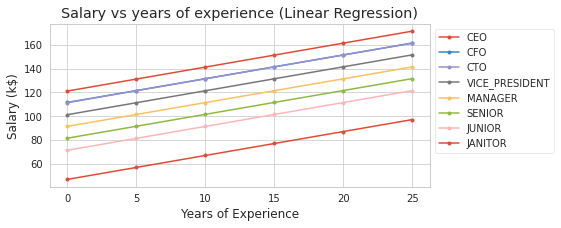

In [26]:
jobList = ["CEO", "CFO", "CTO", "VICE_PRESIDENT", "MANAGER", "SENIOR", "JUNIOR", "JANITOR"]
slopeList = []  #to save the slopes of the regression lines
interceptList = [] #to save the intercepts of the regression lines

for job in jobList:
    df_x = trainDataFrame.loc[trainDataFrame["jobType"] == job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x["yearsExperience"],df_x["salary"])
    slopeList.append(slope)
    interceptList.append(intercept)

X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8,3))
for i in range(8):
    plt.plot(X, slopeList[i] * X + interceptList[i], label = jobList[i], marker = '.')
    plt.legend(bbox_to_anchor = (1, 1))
plt.ylabel("Salary (k$)")
plt.xlabel("Years of Experience")
plt.title("Salary vs years of experience (Linear Regression)")
plt.show()

We can see that salary adn years of experience has a correlation relationship, where more years has highers salary.

### Analyze the relationship between degree type and salary

In [27]:
degreeSalary = spark.sql('''
                  SELECT degree, salary, jobType
                  FROM data
                  ORDER BY salary
                  ''')
degreeSalary.show()

+-----------+------+-------+
|     degree|salary|jobType|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    18|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
|       NONE|    20|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
|       NONE|    20|JANITOR|
+-----------+------+-------+
only showing top 20 rows



Text(0.5, 1.0, 'Salary of degree by jobType')

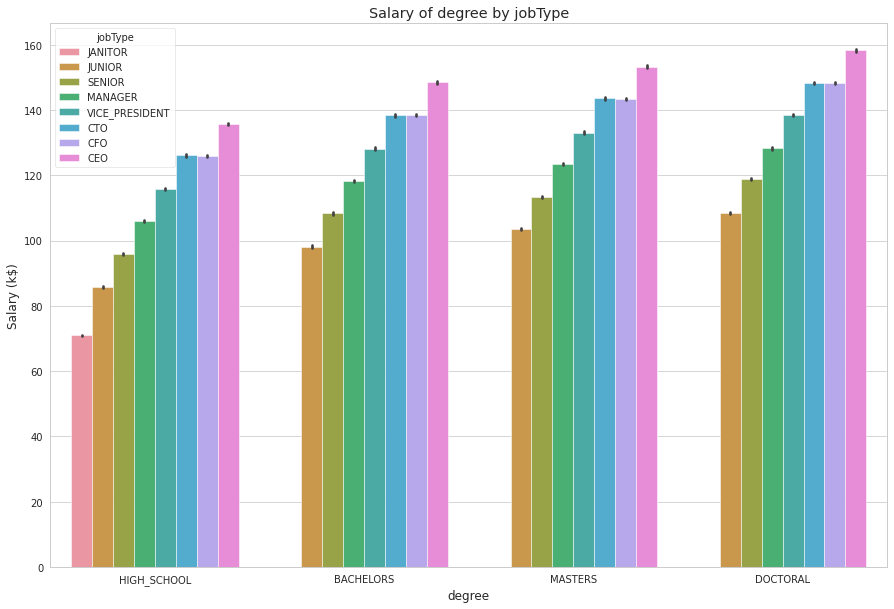

In [28]:
plt.figure(figsize = (15, 10))
sns.barplot(x = "degree", y = "salary", data = degreeSalary.replace("NONE", None).na.drop().toPandas(), hue = "jobType")

plt.ylabel("Salary (k$)")
plt.title("Salary of degree by jobType")

We can see that people with higher degree types has higher salary. In addition, there is no "Janitor" jobtype for people with degree higher or equal to bachelor.

### Analyze the relationship between jobtype with different major and salary

In [29]:
majorSalary = spark.sql('''
                  SELECT jobType, major, salary
                  FROM data
                  ORDER BY salary''')
majorSalary.show()

+-------+-----+------+
|jobType|major|salary|
+-------+-----+------+
|JANITOR| NONE|    17|
|JANITOR| NONE|    18|
|JANITOR| NONE|    18|
|JANITOR| NONE|    18|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    19|
|JANITOR| NONE|    20|
|JANITOR| NONE|    20|
|JANITOR| NONE|    20|
|JANITOR| NONE|    20|
|JANITOR| NONE|    20|
|JANITOR| NONE|    20|
+-------+-----+------+
only showing top 20 rows



Text(0.5, 1.0, 'Salary of jobtypes by major')

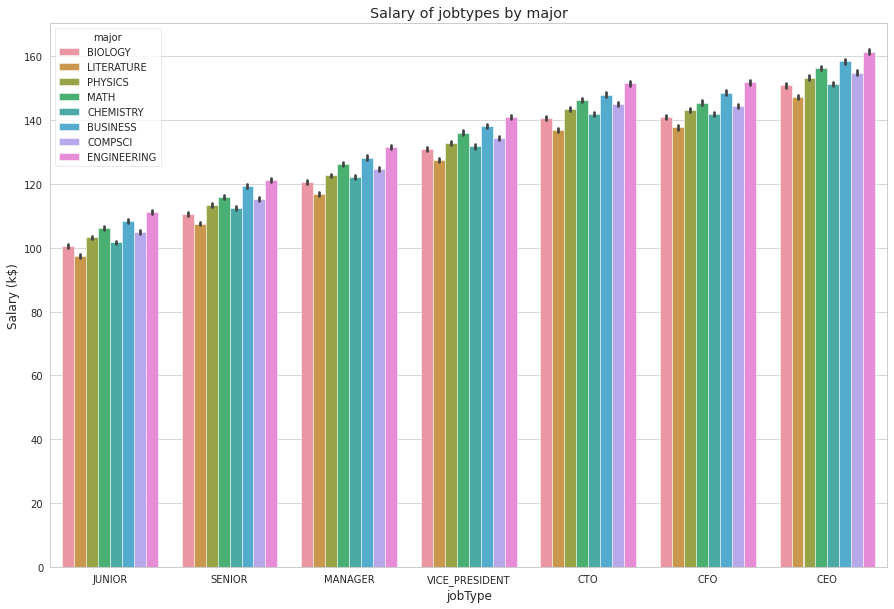

In [30]:
plt.figure(figsize = (15, 10))
sns.barplot(x = "jobType", y = "salary", data = majorSalary.replace("NONE", None).na.drop().toPandas(), hue = "major")
plt.ylabel("Salary (k$)")
plt.title("Salary of jobtypes by major")

### Analyze the relationship between jobtype of different industry and salary

In [31]:
jobtypeIndustrySalary = spark.sql('''
                  SELECT jobType, industry, salary
                  FROM data
                  ORDER BY salary''')
jobtypeIndustrySalary.show()

+-------+---------+------+
|jobType| industry|salary|
+-------+---------+------+
|JANITOR|EDUCATION|    17|
|JANITOR|EDUCATION|    18|
|JANITOR|EDUCATION|    18|
|JANITOR|EDUCATION|    18|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    19|
|JANITOR|EDUCATION|    20|
|JANITOR|EDUCATION|    20|
|JANITOR|EDUCATION|    20|
|JANITOR|EDUCATION|    20|
|JANITOR|EDUCATION|    20|
|JANITOR|EDUCATION|    20|
+-------+---------+------+
only showing top 20 rows



Text(0.5, 1.0, 'Salary of jobtypes by industry')

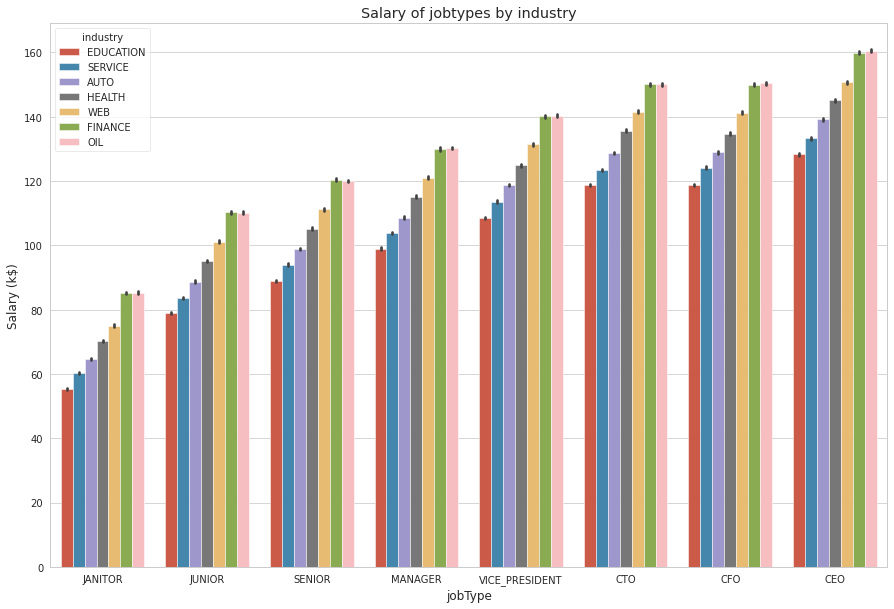

In [32]:
plt.figure(figsize = (15, 10))
sns.barplot(x = "jobType", y = "salary", data = jobtypeIndustrySalary.replace("NONE", None).na.drop().toPandas(), hue = "industry")
plt.ylabel("Salary (k$)")
plt.title("Salary of jobtypes by industry")

# **ML model**

We'll start by making a clone of the dataframe named `trainEncoded`, which will include the pre-processed data.

In [33]:
# create a copy of the dataframe
trainEncoded = train.alias("trainEncoded")
id(trainEncoded) == id(train)

# drop uneeded data
trainEncoded = train.drop("jobId")

**Label Encoding**

Because degree is the only categorical variable in this dataset having a hieracrhy/order, we need encode it with label encoding.

In [34]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

**One Hot Encoding**

The integer encoding is insufficient for category variables with no such ordinal relationship.

In reality, enabling the model to presume a natural ordering across categories and utilizing this encoding may result in poor performance or surprising outcomes (predictions halfway between categories).

In this situation, the integer representation can be encoded once and for all. For each unique integer value, the integer encoded variable is removed and a new binary variable is added.

(https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [35]:
categoricalColumns = ["companyId", "jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + "Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages += [assembler]

In [36]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(trainEncoded)
trainEncoded = pipelineModel.transform(trainEncoded)
selectedCols = ["features"] + trainEncoded.columns
trainEncoded = trainEncoded.select(selectedCols)

In [37]:
trainEncoded.show(5)

+--------------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+-----------+--------------+-----------------+------------+---------------+----------+-------------+-------------+----------------+--------------------+
|            features|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|degreeIndex|companyIdIndex|companyIdclassVec|jobTypeIndex|jobTypeclassVec|majorIndex|majorclassVec|industryIndex|industryclassVec|            features|
+--------------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+-----------+--------------+-----------------+------------+---------------+----------+-------------+-------------+----------------+--------------------+
|(86,[29,82,83,84,...|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|        4.0|          29.0|  (62,[29],[1.0])|         7.

**Train Test Split**

In [38]:
trainSet, testSet = trainEncoded.randomSplit([0.9, 0.1], seed = 42)
print("There are {} training examples and {} test examples.".format(trainSet.count(), testSet.count()))

There are 899465 training examples and 100530 test examples.


**Gradient Boosting Tree Regression**

In [39]:
gbt = GBTRegressor(featuresCol = "features", labelCol = "salary", maxBins = 20, maxDepth = 12)
gbt_model = gbt.fit(trainSet)

**Linear Regression**

In [40]:
lr = LinearRegression(featuresCol = "features", labelCol = "salary", maxIter = 10000, regParam = 0.3, elasticNetParam = 0.8)
lr_model = lr.fit(trainSet)

# **Prediction results**

**Prediction of Gradient Boosting Tree Regression**

In [41]:
predictionsGBT = gbt_model.transform(testSet)

The root mean squared error (RMSE) and the R-squared (R2) use to quantify how well a model fits a dataset.

(https://www.statology.org/rmse-vs-r-squared/)

RMSE: 
* A metric that measures the average distance between predicted and observed values in a dataset. 
* The lower the RMSE, the better a model fits a dataset.

In [42]:
evaluator = RegressionEvaluator(labelCol = "salary", predictionCol = "prediction", metricName = "rmse")
rmseGBT = evaluator.evaluate(predictionsGBT)
rmseGBT

19.38908614218119

R2: 
* A metric that indicates how much of the variance in a regression model's response variable can be explained by the predictor variables. This number can be anywhere between 0 and 1. 
* The higher the R2 value, the better a model fits a dataset.

In [43]:
evaluator = RegressionEvaluator(labelCol = "salary", predictionCol = "prediction", metricName = "r2")
r2GBT = evaluator.evaluate(predictionsGBT)
r2GBT

0.7488410892512185

In [44]:
rfResultsGBT = predictionsGBT.toPandas()

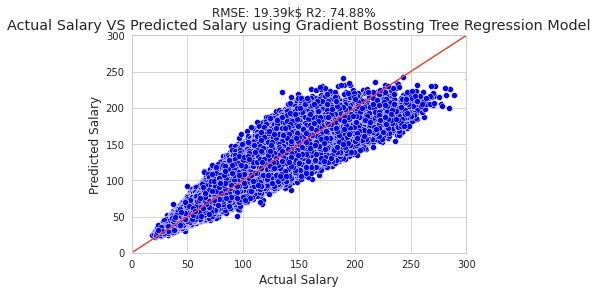

In [45]:
sns.scatterplot(x = "salary", y = "prediction", data = rfResultsGBT, color = "blue")
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.suptitle("RMSE: {:.2f}k$ R2: {:.2f}%".format(rmseGBT, r2GBT*100))
plt.title("Actual Salary VS Predicted Salary using Gradient Bossting Tree Regression Model")
plt.show()

In [46]:
print("RMSE: {:.2f}k$ \nR2: {:.2f}%".format(rmseGBT, r2GBT*100))

RMSE: 19.39k$ 
R2: 74.88%


**Prediction of Linear Regression**

In [47]:
predictionsLR = lr_model.transform(testSet)

In [48]:
evaluator = RegressionEvaluator(labelCol = "salary", predictionCol = "prediction", metricName = "rmse")
rmseLR = evaluator.evaluate(predictionsLR)
rmseLR

20.035363275965622

In [49]:
evaluator = RegressionEvaluator(labelCol = "salary", predictionCol = "prediction", metricName = "r2")
r2LR = evaluator.evaluate(predictionsLR)
r2LR

0.7318187854283899

In [50]:
rfResultsLR = predictionsLR.toPandas()

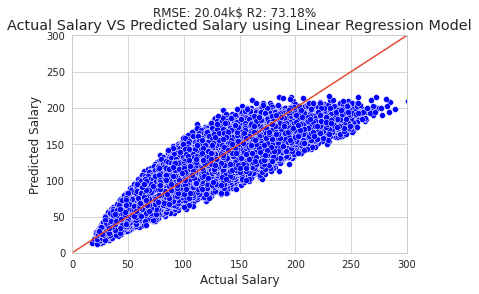

In [51]:
sns.scatterplot(x = "salary", y = "prediction", data = rfResultsLR, color = "blue")
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.suptitle("RMSE: {:.2f}k$ R2: {:.2f}%".format(rmseLR, r2LR*100))
plt.title("Actual Salary VS Predicted Salary using Linear Regression Model")
plt.show()

In [52]:
print("RMSE: {:.2f}k$ \nR2: {:.2f}%".format(rmseLR, r2LR*100))

RMSE: 20.04k$ 
R2: 73.18%


We can observe that the system forecasts higher incomes below 130k\$ and begins to underestimate salaries over 175k\$. This could be owing to the salary distribution's proper skewness. 

Overall, both in terms of RMSE and R2, the results are satisfactory. A proper hyperparameter tuning and feature engineering on the data could yield much more benefits.

We also could say that since the RMSE of GBT is lower and R2 of GBT is higher than of LR. Hence, for this dataset, the GBT regression is a better model.

# **Expand - Comparing other models**

**Create models**

In [53]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(family = "gaussian", labelCol = "salary", link = "identity", maxIter = 10, regParam = 0.3)
glr_model = glr.fit(trainSet)

In [54]:
from pyspark.ml.regression import DecisionTreeRegressor
dtr = DecisionTreeRegressor(featuresCol = "features", labelCol = "salary")
dtr_model = dtr.fit(trainSet)

In [55]:
from pyspark.ml.regression import RandomForestRegressor
rfg = RandomForestRegressor(featuresCol = "features", labelCol = "salary")
rfg_model = rfg.fit(trainSet)

**Interpret Root-mean-square deviation (RMSE) and R-squared in Regression Analysis**

In [56]:
resultsRMSE = [rmseGBT, rmseLR]
resultsR2 = [r2GBT, r2LR]
models = [glr_model, dtr_model, rfg_model]

for model in models:
    prediction = model.transform(testSet)
    evaluatorRMSE = RegressionEvaluator(labelCol = "salary", predictionCol = "prediction", metricName = "rmse")
    evaluatorR2 = RegressionEvaluator(labelCol = "salary", predictionCol = "prediction", metricName = "r2")
    resultsRMSE.append(evaluatorRMSE.evaluate(prediction))
    resultsR2.append(evaluatorR2.evaluate(prediction))

In [57]:
names = ["Gradient Boosting Tree Regression", "Linear Regression", "Generalized Linear Regression", "Decision Tree Regressor", "Random Forest Regressor"]

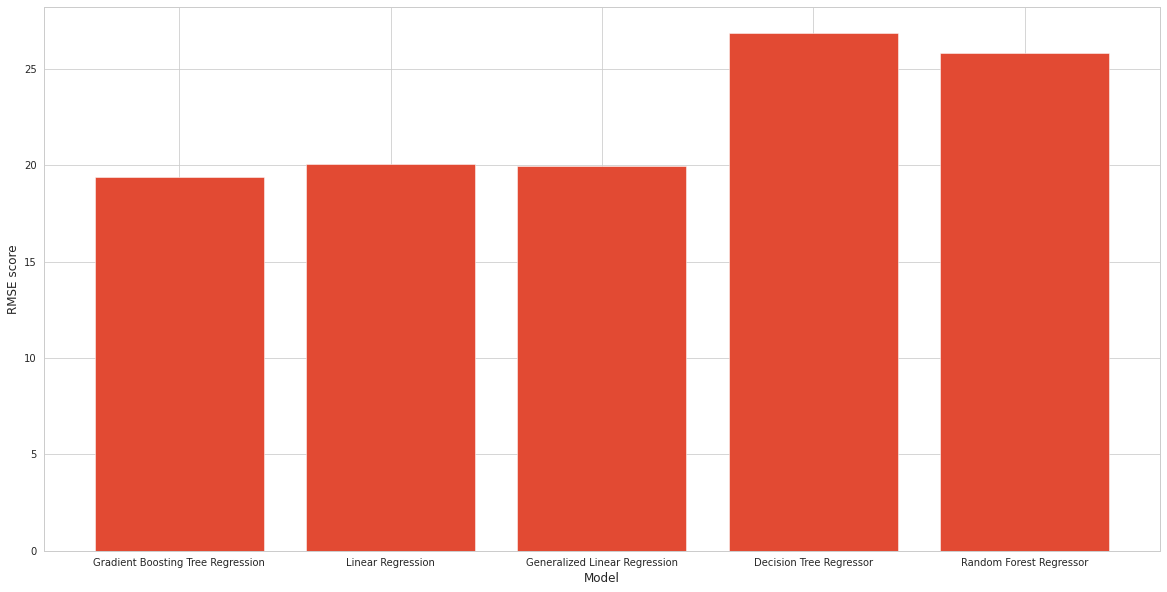

In [58]:
plt.figure(figsize = (20, 10))
plt.bar(names, resultsRMSE)
plt.xlabel("Model")
plt.ylabel("RMSE score")
plt.show()

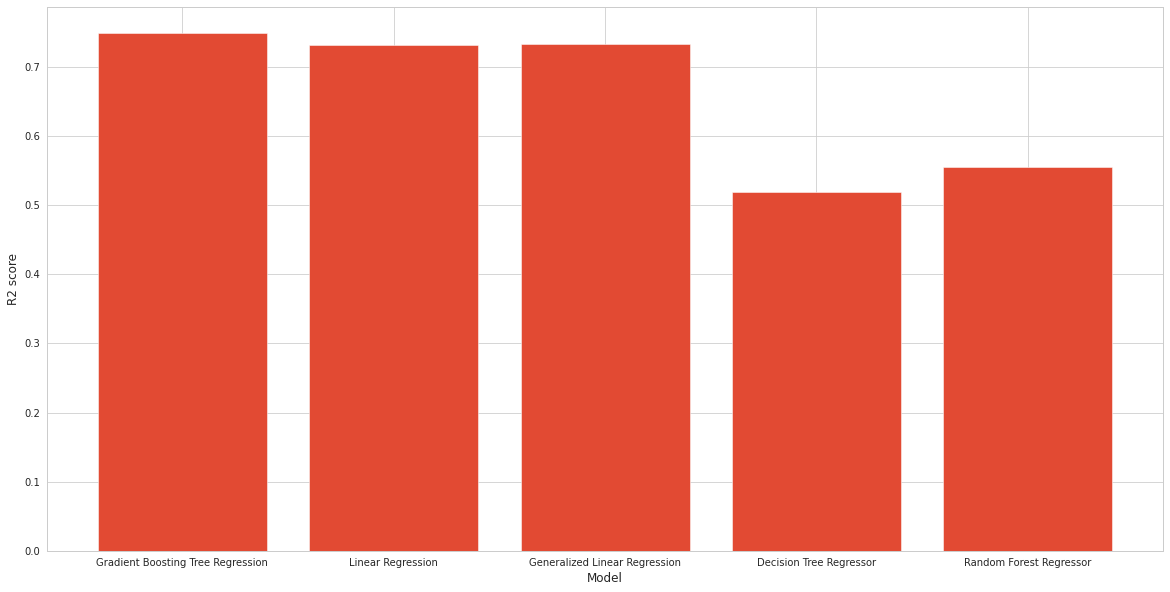

In [59]:
plt.figure(figsize = (20, 10))
plt.bar(names, resultsR2)
plt.xlabel("Model")
plt.ylabel("R2 score")
plt.show()

According to the definition of RMSE and R2, we knows that:
* The lower the RMSE, the better a model fits a dataset.
* The higher the R2 value, the better a model fits a dataset.

Hence, we can conclude that the Gradient Boosting Tree Regression is still the model fits the dataset the best.

In [67]:
sc.stop()